In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.20.0


d:\Coding Related\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


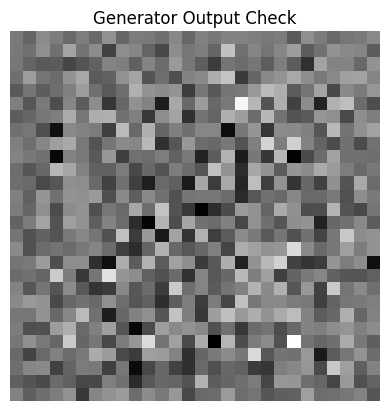

In [2]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same",
                                     use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, 0] * 0.5) + 0.5, cmap='gray')
plt.axis("off")
plt.title("Generator Output Check")
plt.show()


In [3]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))   # from_logits=True → no activation

    return model

discriminator = make_discriminator_model()
disc_output = discriminator(generated_image)
print("Discriminator output:", disc_output)


Discriminator output: tf.Tensor([[-0.00016338]], shape=(1, 1), dtype=float32)


d:\Coding Related\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [5]:
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [6]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions * 0.5) + 0.5   # [-1,1] → [0,1]

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    os.makedirs("generated_images", exist_ok=True)
    filename = f"generated_images/epoch_{epoch:04d}.png"
    plt.savefig(filename)
    plt.close()
    print(f"Saved: {filename}")


In [7]:
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()
        gen_loss_avg = 0.0
        disc_loss_avg = 0.0
        steps = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_avg += gen_loss
            disc_loss_avg += disc_loss
            steps += 1

        gen_loss_avg /= steps
        disc_loss_avg /= steps

        print(f"Epoch {epoch}/{epochs} | "
              f"Gen Loss: {gen_loss_avg:.4f} | Disc Loss: {disc_loss_avg:.4f} | "
              f"Time: {time.time() - start:.2f}s")

        generate_and_save_images(generator, epoch, seed)


In [8]:
def main(batch_size=128, epochs=50):
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

    train_images = train_images.astype("float32")
    train_images = (train_images - 127.5) / 127.5
    train_images = np.expand_dims(train_images, axis=-1)

    BUFFER_SIZE = train_images.shape[0]

    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices(train_images)
        .shuffle(BUFFER_SIZE)
        .batch(batch_size, drop_remainder=True)
    )

    print("Training dataset ready: ", BUFFER_SIZE, " images")

    train(train_dataset, epochs)

main(batch_size=128, epochs=50)


Training dataset ready:  60000  images
Epoch 1/50 | Gen Loss: 0.8009 | Disc Loss: 1.1498 | Time: 87.27s
Saved: generated_images/epoch_0001.png
Epoch 2/50 | Gen Loss: 0.8322 | Disc Loss: 1.2734 | Time: 78.97s
Saved: generated_images/epoch_0002.png
Epoch 3/50 | Gen Loss: 0.8636 | Disc Loss: 1.2899 | Time: 78.33s
Saved: generated_images/epoch_0003.png
Epoch 4/50 | Gen Loss: 0.8211 | Disc Loss: 1.2976 | Time: 87.07s
Saved: generated_images/epoch_0004.png
Epoch 5/50 | Gen Loss: 0.8671 | Disc Loss: 1.2490 | Time: 179.72s
Saved: generated_images/epoch_0005.png
Epoch 6/50 | Gen Loss: 0.9137 | Disc Loss: 1.2489 | Time: 209.21s
Saved: generated_images/epoch_0006.png


KeyboardInterrupt: 